In [2]:
# !pip install textblob

In [3]:
import urllib.request
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import re
from PIL import Image
from io import BytesIO
from kiwipiepy import Kiwi
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import font_manager
import collections
from tqdm import tqdm
import pymysql

In [4]:
con = pymysql.connect(
    host='localhost',
    user='root',
    password='1111',
    db='yorehalre',
    charset='utf8'
)

data = pd.read_sql("SELECT recipeID, recipe_name, summary, ingredient_name, category, recipe_image_link FROM recipe_info", con)
data_re = pd.read_sql("SELECT category, recipeID, recipe_name, user_id, rating, review_content FROM user_review", con)

con.close()

C:\Users\SSO\AppData\Local\Temp\ipykernel_21068\3379523620.py:9: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data = pd.read_sql("SELECT recipeID, recipe_name, summary, ingredient_name, category, recipe_image_link FROM recipe_info", con)
C:\Users\SSO\AppData\Local\Temp\ipykernel_21068\3379523620.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  data_re = pd.read_sql("SELECT category, recipeID, recipe_name, user_id, rating, review_content FROM user_review", con)


In [5]:
# data = pd.read_csv('weaviate_data(임시).csv')
# data_re = pd.read_csv('user_review.csv')

In [6]:
data_re.head()

,category,recipeID,recipe_name,user_id,rating,review_content
0,간 건강,765,카레 해물 파스타,3366,3,참고해서 잘 해먹었습니다~ 우유가 없어서 카레를 그냥 재료들과 볶았는데 나쁘지 않았어요
1,간 건강,768,생생정보 오이미역냉국 황금레시피,1013,5,애들이 맛있다고 잘먹어요..
2,간 건강,768,생생정보 오이미역냉국 황금레시피,1173,5,정말 맛나요~
3,간 건강,768,생생정보 오이미역냉국 황금레시피,1188,5,냉면육수 사다가 먹곤 했는데 이거 짱이예요!
4,간 건강,768,생생정보 오이미역냉국 황금레시피,1271,5,여름에 별미 너무 맛있게 먹고있어요^^솔직히 요리에관심이 없다보니 만들줄도 모르고~...


In [7]:
source = []
for ingredient_name in data['ingredient_name']:
    ingredient_name_str = str(ingredient_name)
    if '양념' in ingredient_name_str:
        ingredient_matches = re.findall(r'\[.*?\](.*?)\양념', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    else:
        ingredient_matches = re.findall(r'\[.*?\](.*)', ingredient_name_str)
        source_per_ingredient = []
        for ingredient_match in ingredient_matches:
            ingredient_cleaned = re.sub(r'[0-9]+[가-힣]+', '', ingredient_match).strip().split()
            for ing in ingredient_cleaned:
                if ing:
                    ingredient_final = re.sub(r'[^가-힣\s]', '', ing).strip()
                    if ingredient_final:
                        source_per_ingredient.extend(ingredient_final.split())
    # if source_per_ingredient:
    source.append(source_per_ingredient)

In [8]:
data['main_source'] = source

In [9]:
data_all = pd.DataFrame(columns=['recipe_name', 'all'])
data_all['recipe_name'] = data['recipe_name']
# data_re의 각 행을 반복하면서 조건을 확인하고 데이터 추가
for index, row in data_re.iterrows():
    for i in data['recipe_name']:
        if row.recipe_name == i:
            data_all = pd.concat([data_all, pd.DataFrame({'recipe_name': [row['recipe_name']], 'all': [row['review_content']]})], ignore_index=True)


In [10]:
data_all = data_all.groupby('recipe_name')['all'].apply(list).reset_index()

In [11]:
data_all.loc[data_all['recipe_name'] == '우엉양배추볶음밥']

,recipe_name,all
605,우엉양배추볶음밥,[nan]


In [12]:
df = pd.merge(data, data_all, on=['recipe_name'], how='outer')

In [13]:
df.head()

,recipeID,recipe_name,summary,ingredient_name,category,recipe_image_link,main_source,all
0,0,우엉양배추볶음밥,찬밥이 기다려지는 우엉양배추볶음밥입니다.,[재료] 찬 밥 적당량 양배추 적당량 우엉 적당량 느타리버섯 조금 다시마 ...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[찬, 밥, 적당량, 양배추, 적당량, 우엉, 적당량, 느타리버섯, 조금, 다시마,...",[nan]
1,1,아삭아삭 연근장아찌 만들기,연근은 비타민C와 식이섬유소가 풍부하고 빈혈예방에 탁월하고 코피가 자주나는 아이들에...,[재료] 연근 [양념비율(200ml 계량컵 기준)] 간장 1 물 1 설탕 0...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,[연근],"[nan, 맛있어욤 다름 다이어트 음식도 많이 알려주세요!♡♡♡\r\n다름이아니라 ..."
2,2,아보카도 스프레드 연어 샌드위치,근사한 오픈샌드위치 만드는 법을 알려드립니다.,[재료] 식빵 1장 훈제연어 슬라이스 2쪽 오이 1/2개 크랜베리 약간 [양...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[식빵, 훈제연어, 슬라이스, 오이, 크랜베리, 약간]","[nan, 와 이거 진짜 너무 맛있어요 ^^\r\n독일사는데 간단하게 먹기 딱 좋네..."
3,3,아보카도 멜론 냉수프 만들기,만들기 간단하고 맛이 고급스러운 멜론 냉수프,[재료] 아보카도 1/4개 멜론 1/4개 우유(농도 조절용으로) 약간,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[아보카도, 멜론, 우유농도, 조절용으로, 약간]",[nan]
4,4,훈제연어샐러드 만드는법,연어는 어떻게 먹어도 좋지요~ 다양한 요리 방법 중 이번엔 샐러드로 만들어 보았어요...,[재료] 훈제연어 180g 양상추 치커리 양파 방울토마토 블랙올리브 크루...,저칼로리 다이어트,https://recipe1.ezmember.co.kr/cache/recipe/20...,"[훈제연어, 양상추, 치커리, 양파, 방울토마토, 블랙올리브, 크루통]","[nan, 정말 맛납니다!!! 감사드려요!]"


In [14]:
kiwi = Kiwi()

def extract_keywords(text):
    stop_words = ['물', '약간', '적당', '적당량', '조금', '때', '레시피', '요리', '저', '거', '것', '수', '나']
    keywords = []
    text = text.str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    for title in text:
        titles = []
        result = kiwi.analyze(title)
        for token, tag, _ , _ in result[0][0]:
            if tag[0] in 'NN':
                if token not in stop_words and not re.match(r'.*\W.*', token):
                    titles.append(token.strip())
        keywords.append(titles)
    return keywords

In [15]:
name = extract_keywords(df['recipe_name'].apply(str))
summary = extract_keywords(df['summary'].apply(str))
# source = extract_keywords(df['main_source'].apply(str))

In [16]:
review = extract_keywords(df['all'].apply(str))

In [17]:
list_all = []

for item_1, item_2, item_3, item_4, item_5 in zip(name, summary, df['main_source'], review, df['category']):
    combined_list = item_1 + item_2 + item_3 + item_4 + [item_5]
    list_all.append(combined_list)

In [18]:
df['all'] = list_all

In [19]:
all_keyword = []
for i in df['all']:
    for item in i:
        all_keyword.append(item)

unique_keyword = set(all_keyword)

In [20]:
total_keyword_count = len(set(data['recipe_name']))
keyword_count_dict = dict.fromkeys(unique_keyword)

for keyword_list in df['all']:
    for keyword in keyword_list:
        if keyword_count_dict[keyword.strip()] == None:
            keyword_count_dict[keyword.strip()] = 1
        else:
            keyword_count_dict[keyword.strip()] += 1

In [21]:
keyword_count_dict
sorted_data_dict = dict(sorted(keyword_count_dict.items(), key=lambda item: item[1], reverse=True))
sorted_data_dict

{'감사': 1351,
 '맛': 935,
 '밥': 374,
 '양파': 357,
 '무': 335,
 '양념': 333,
 '아이': 258,
 '처음': 237,
 '약간': 232,
 '고등어': 215,
 '두부': 214,
 '소금': 213,
 '전': 213,
 '반찬': 211,
 '간': 194,
 '최고': 192,
 '설탕': 190,
 '재료': 187,
 '추가': 185,
 '남편': 184,
 '마늘': 184,
 '조림': 184,
 '간장': 183,
 '번': 175,
 '신랑': 175,
 '건강': 175,
 '소스': 172,
 '덕분': 171,
 '당근': 170,
 '집': 169,
 '성공': 155,
 '무침': 142,
 '미역': 139,
 '가루': 135,
 '샐러드': 132,
 '청양고추': 132,
 '우유': 131,
 '닭': 130,
 '물': 130,
 '국물': 123,
 '입맛': 123,
 '양': 122,
 '정도': 121,
 '감자': 118,
 '오이': 117,
 '법': 117,
 '대파': 115,
 '버섯': 115,
 '가슴살': 114,
 '대신': 113,
 '저녁': 112,
 '고추': 111,
 '볶음': 111,
 '양념장': 111,
 '영양': 110,
 '분': 110,
 '중': 109,
 '향': 107,
 '배': 106,
 '계란': 106,
 '소개': 106,
 '생각': 104,
 '다음': 104,
 '다이어트': 102,
 '부추': 98,
 '오늘': 95,
 '들깨': 95,
 '표고버섯': 94,
 '반': 94,
 '개': 94,
 '듯': 93,
 '그릇': 91,
 '고추장': 91,
 '깻잎': 89,
 '양배추': 88,
 '된장': 88,
 '음식': 87,
 '새우': 86,
 '단호박': 85,
 '스푼': 84,
 '하나': 83,
 '사과': 83,
 '달걀': 81,
 '식감': 81,
 '꿀': 81,
 '김치':

In [22]:
keyword_representation = pd.DataFrame(0, columns=sorted(unique_keyword), index=df['recipeID'])

In [23]:
for index, keyword_list in tqdm(enumerate(df['all'])):
    keyword_list = [keyword.strip() for keyword in keyword_list]
    recipeID = df['recipeID'].iloc[index]
    keyword_counts = pd.Series(keyword_list).value_counts()
    keyword_representation.loc[recipeID, keyword_counts.index] += keyword_counts.values

874it [00:02, 325.46it/s]


In [24]:
keyword_representation

,1숫,2손다,3스픈,n꾸덕,n마싯게,n상콤,ᆢ,ᆢ저,ㅋ넘,ㅋ존,...,흰우유,흰자,흰콩,흰후추,흰후추가루,히,히트,힌트,힐링,힘
recipeID,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
866,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
868,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
869,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
max_values = keyword_representation.max(axis=1)

In [26]:
max_values

recipeID
0       4
1       5
2       2
3       3
4       4
       ..
866     2
868     4
869    28
870     4
872     8
Length: 874, dtype: int64

In [47]:
category_max_list = []
for number, cat in zip(max_values, df['category']):
    total_cat = ','.join([cat] * number * 5)
    category_max_list.append(total_cat)


In [48]:
list_total = []

for item_1, item_2 in zip(df['all'], category_max_list):
    combined_list = item_1 + [item_2]
    list_total.append(combined_list)

In [49]:
df['all'] = list_total

In [30]:
counts_ingr = collections.Counter(all_keyword)

In [31]:
print (counts_ingr.most_common(20))

[('감사', 1351), ('맛', 935), ('밥', 374), ('양파', 357), ('무', 335), ('양념', 333), ('아이', 258), ('처음', 237), ('약간', 232), ('고등어', 215), ('두부', 214), ('소금', 213), ('전', 213), ('반찬', 211), ('간', 194), ('최고', 192), ('설탕', 190), ('재료', 187), ('추가', 185), ('마늘', 184)]


In [32]:
print (counts_ingr.most_common()[-20:])

[('룸메', 1), ('뭍', 1), ('수정', 1), ('백숙', 1), ('배수', 1), ('사흘', 1), ('암송', 1), ('바베큐', 1), ('실온', 1), ('쯤', 1), ('맛있어요힛', 1), ('형제', 1), ('대대', 1), ('맛잇엉', 1), ('깻잎순', 1), ('냉동고', 1), ('저의', 1), ('셀러리잎', 1), ('초고예요', 1), ('하이라이스', 1)]


In [78]:
downsampling = 1e-1
word2vec_model = Word2Vec(vector_size=300, window=5, min_count=5, workers=4, sample = downsampling, sg=1)
word2vec_model.build_vocab(df['all'])
#모든 단어 벡터에 대해 1로 설정하고 Word2Vec 모델에서 단어 벡터를 수정할 수 있다
word2vec_model.wv.vectors_lockf = np.ones(len(word2vec_model.wv), dtype=np.float32)
word2vec_model.train(df['all'], total_examples = word2vec_model.corpus_count, epochs = 15)
word2vec_vocab = word2vec_model.wv.key_to_index

In [79]:
print(word2vec_vocab)

{'감사': 0, '맛': 1, '밥': 2, '양파': 3, '무': 4, '양념': 5, '아이': 6, '처음': 7, '약간': 8, '고등어': 9, '두부': 10, '소금': 11, '전': 12, '반찬': 13, '간': 14, '최고': 15, '설탕': 16, '재료': 17, '추가': 18, '마늘': 19, '조림': 20, '남편': 21, '간장': 22, '번': 23, '신랑': 24, '건강': 25, '소스': 26, '덕분': 27, '당근': 28, '집': 29, '성공': 30, '무침': 31, '미역': 32, '가루': 33, '샐러드': 34, '청양고추': 35, '우유': 36, '닭': 37, '물': 38, '입맛': 39, '국물': 40, '양': 41, '정도': 42, '감자': 43, '오이': 44, '법': 45, '버섯': 46, '대파': 47, '가슴살': 48, '대신': 49, '저녁': 50, '고추': 51, '양념장': 52, '볶음': 53, '영양': 54, '분': 55, '중': 56, '향': 57, '배': 58, '소개': 59, '계란': 60, '다음': 61, '생각': 62, '다이어트': 63, '부추': 64, '오늘': 65, '들깨': 66, '반': 67, '표고버섯': 68, '개': 69, '듯': 70, '그릇': 71, '고추장': 72, '깻잎': 73, '양배추': 74, '된장': 75, '음식': 76, '새우': 77, '단호박': 78, '스푼': 79, '사과': 80, '하나': 81, '달걀': 82, '식감': 83, '꿀': 84, '굿': 85, '김치': 86, '가족': 87, '쌀': 88, '끼': 89, '가지': 90, '변비': 91, '간식': 92, '파프리카': 93, '사진': 94, '생강': 95, '대추': 96, '야채': 97, '아침': 98, '실패': 99, '칭찬': 100, '매운탕'

In [80]:
word2vec_model.wv.vectors.shape

(1244, 300)

In [81]:
similar_words = {search_term: [item[0] for item in word2vec_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['연근']}
similar_words

{'연근': ['연근전', '본연', '연근조림', '킬러', '주먹밥']}

In [82]:
print(word2vec_model.wv.most_similar("연근"))

[('연근전', 0.7634328007698059), ('본연', 0.7288209199905396), ('연근조림', 0.6690801978111267), ('킬러', 0.6652787327766418), ('주먹밥', 0.6444249749183655), ('칩', 0.6391143202781677), ('카레', 0.6312434673309326), ('소', 0.6272323727607727), ('반응', 0.6237403750419617), ('예전', 0.6104740500450134)]


In [83]:
print(word2vec_model.wv["연근"])

[-5.53604448e-03  6.17691576e-01 -1.83641627e-01 -1.39198378e-01
  2.08103999e-01 -4.07085598e-01 -1.34519979e-01  2.71644235e-01
 -8.81625563e-02 -3.21823984e-01  1.69506818e-01 -1.82869047e-01
  2.69756496e-01  2.24167883e-01 -6.82873651e-02 -1.76411375e-01
  1.91064358e-01 -7.55933821e-02  9.52966064e-02  6.65687770e-02
 -2.82784462e-01 -7.41147324e-02  3.23186964e-02  1.48866996e-01
  1.18890494e-01  4.72167164e-01 -4.05930430e-01  1.69385090e-01
  1.80012316e-01 -5.72117902e-02  1.23684846e-01  2.36647606e-01
 -1.29855737e-01 -4.36938480e-02 -2.49900445e-01  3.10792506e-01
 -2.18513086e-01 -3.95886481e-01  1.70112327e-02 -6.57661557e-02
  6.40189722e-02 -1.38745189e-01  2.06965372e-01 -8.98870453e-02
  3.81589048e-02  3.97560477e-01  2.49790594e-01 -4.55046557e-02
 -2.40413733e-02  2.99984485e-01 -1.23713247e-01  5.55581972e-02
 -1.40978336e-01  8.19461644e-02  2.53646970e-01  2.34383330e-01
  2.11415321e-01 -1.04974270e-01 -5.29871583e-01 -1.87443830e-02
 -1.46092877e-01  1.02890

In [84]:
print(word2vec_model.wv.similarity('무', '고등어'))

0.5333093


In [85]:
print(word2vec_model.wv.similarity('바나나', '다이어트'))

0.51813453


In [86]:
def get_document_vectors(document_list):
    document_embedding_list = []

    # 각 문서에 대해서
    for line in document_list:
        doc2vec = None
        count = 0
        for word in line:
            if word in list(word2vec_model.wv.index_to_key):
                count += 1
                # 해당 문서에 있는 모든 단어들의 벡터값을 더한다.
                if doc2vec is None:
                    doc2vec = word2vec_model.wv[word]
                else:
                    doc2vec = doc2vec + word2vec_model.wv[word]

        if doc2vec is not None:
            # 단어 벡터를 모두 더한 벡터의 값을 문서 길이로 나눠준다.
            doc2vec = doc2vec / count
            document_embedding_list.append(doc2vec)

    # 각 문서에 대한 문서 벡터 리스트를 리턴
    return document_embedding_list

In [87]:
document_embedding_list = get_document_vectors(df['all'])
print('문서 벡터의 수 :',len(document_embedding_list))

문서 벡터의 수 : 874


In [88]:
cosine_similarities = cosine_similarity(document_embedding_list, document_embedding_list)
print('코사인 유사도 매트릭스의 크기 :',cosine_similarities.shape)

코사인 유사도 매트릭스의 크기 : (874, 874)


In [89]:
def recommendations(title):
    recipes = df[['recipe_name', 'category', 'recipe_image_link']]

    # 레시피의 제목을 입력하면 해당 제목의 인덱스를 리턴받아 idx에 저장.
    indices = pd.Series(df.index, index = df['recipe_name']).drop_duplicates()    
    idx = indices[title]

    # 입력된 레시피와 유사한 레시피 5개 선정.
    sim_scores = list(enumerate(cosine_similarities[idx]))
    sim_scores = sorted(sim_scores, key = lambda x: x[1], reverse = True)
    sim_scores = sim_scores[1:6]

    # 가장 유사한 레시피의 인덱스
    recipe_indices = [i[0] for i in sim_scores]

    # 전체 데이터프레임에서 해당 인덱스의 행만 추출. 5개의 행을 가진다.
    recommend = recipes.iloc[recipe_indices].reset_index(drop=True)
    print(recommend[['recipe_name', 'category']])

    fig = plt.figure(figsize=(20, 30))
    font_path = "malgun.ttf"
    font_prop = font_manager.FontProperties(fname=font_path)

    # 데이터프레임으로부터 순차적으로 이미지를 출력
    for index, row in recommend.iterrows():
        response = requests.get(row['recipe_image_link'])
        img = Image.open(BytesIO(response.content))
        fig.add_subplot(1, 5, index + 1)
        plt.imshow(img)
        plt.title(row['recipe_name'])

                   recipe_name   category
0                    양배추 밀푀유나베         변비
1             호두를 넣은 강된장과 양배추쌈   머슬업 다이어트
2                    양배추 밀푀유나베       위 건강
3  양배추쌈밥*쌈밥*양배추*양배추효능*별미밥*한끼식사  저칼로리 다이어트
4                      양배추 된장국       위 건강


c:\Users\SSO\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  func(*args, **kwargs)
c:\Users\SSO\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 48176 (\N{HANGUL SYLLABLE BAE}) missing from current font.
  func(*args, **kwargs)
c:\Users\SSO\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 52628 (\N{HANGUL SYLLABLE CU}) missing from current font.
  func(*args, **kwargs)
c:\Users\SSO\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 48128 (\N{HANGUL SYLLABLE MIL}) missing from current font.
  func(*args, **kwargs)
c:\Users\SSO\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 54336 (\N{HANGUL SYLLABLE POE}) missing from current font.
  func(*args, **kwargs)
c:\Users\SSO\anaconda3\Lib\site-packages\IPython\core\events.py:82: UserWarning: Glyph 50976 (\N{HANGUL SYLLABLE YU}) missing from current font.
  fun

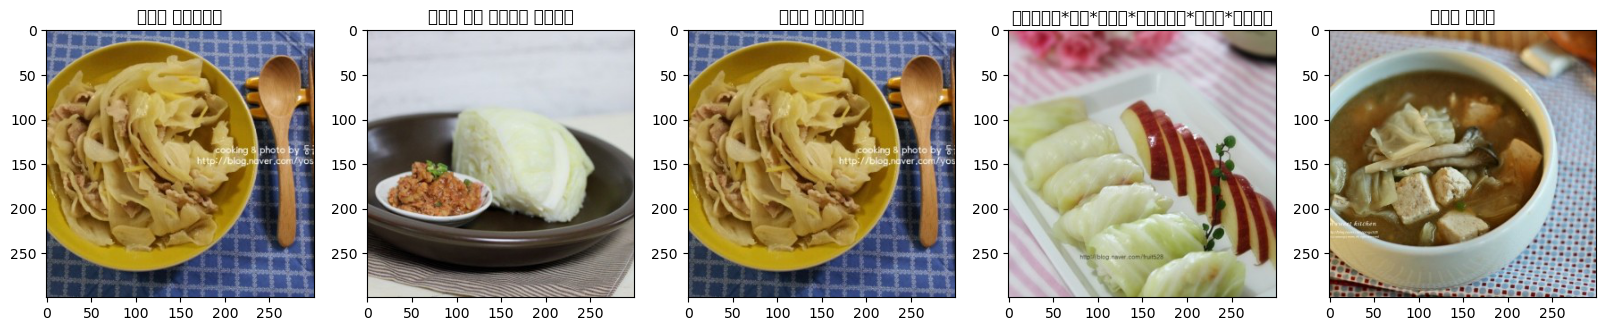

In [90]:
recommendations("우엉양배추볶음밥")

In [45]:
# word2vec_model.save("recipe_word2vec_model.model")

In [46]:
# word2vec_model = Word2Vec.load("recipe_word2vec_model.model")